In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler
import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
Dataset_dir = ["./train.csv", "./store.csv","./test.csv"]
pd.options.display.max_columns = None

In [3]:
def load_data(dir):
    data = pd.read_csv(dir[0],parse_dates=[2])
    store = pd.read_csv(dir[1])
    test = pd.read_csv(dir[2],parse_dates=[3])
    return data,store,test

In [4]:
train,store,test = load_data(Dataset_dir)
train = train[train['Open'] != 0]
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')
print(train.columns)
print(test.columns)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')
Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')


In [5]:
#对时间序列进行分析
#总的销售趋势2013-2015年
# train['date'] = pd.to_datetime(train.Date)
# data = train.loc[:,['Sales']]
# data = data.set_index(train.date)
# data.plot()

# weekly = data.resample('W').sum()
# weekly.plot()

# dayily = data.resample('D').sum()
# dayily.plot()

In [6]:
TESTID = test['Id']

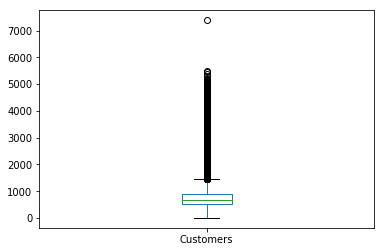

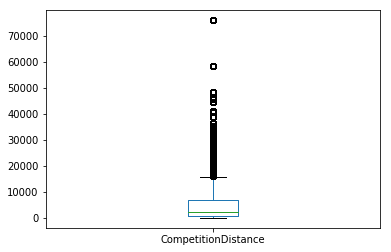

In [7]:
train.Customers.plot(kind='box')
plt.show()
train.CompetitionDistance.plot(kind='box')
plt.show()

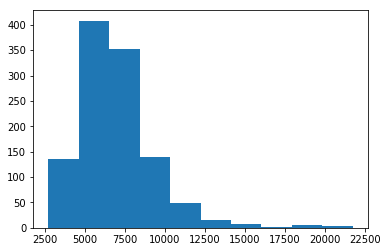

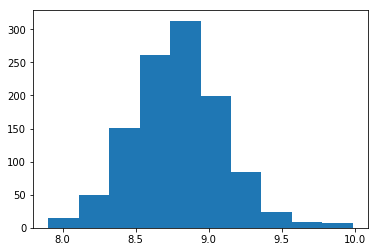

In [8]:
sales_mean = train.groupby('Store')['Sales'].mean()
plt.hist(sales_mean)
plt.show()
plt.hist(np.log1p(sales_mean))
plt.show()

In [9]:
Store_DaysWeek = train.groupby(['Store','DayOfWeek'])
sw_mean = Store_DaysWeek["Sales"].mean()

In [10]:
def build_feature(data,istrain):
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    #CART回归树不需要预处理数据和NAn值
#     distance_max = max(data.CompetitionDistance)
#     data.CompetitionDistance.mask(data.CompetitionDistance.isna(),other=distance_max,inplace=True)
#     print(data.CompetitionDistance.isnull().any())
#     min_max_scaler = MinMaxScaler()
#     scaledata = min_max_scaler.fit_transform(data[['CompetitionDistance']])
#     data.drop("CompetitionDistance",axis=1)
#     data['CompetitionDistance'] = scaledata
    #时间序列问题 需要考虑进时间的因素
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    
    if istrain:
        #data.drop(['Store','Open','Date','Customers','PromoInterval',],axis=1,inplace=True)
        data.drop(['Store','Open','Date','Customers','PromoInterval','SchoolHoliday','Promo2','StateHoliday','Promo2SinceWeek'],axis=1,inplace=True)
    else:
        #data.drop(['Id','Store','Open','Date','PromoInterval',],axis=1,inplace=True)
        data.drop(['Id','Store','Open','Date','PromoInterval','SchoolHoliday','Promo2','StateHoliday','Promo2SinceWeek'],axis=1,inplace=True)
    print(data.columns)

In [11]:
#build train data
build_feature(train,True)
#build test data
build_feature(test,False)

Index(['DayOfWeek', 'Sales', 'Promo', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2SinceYear', 'Year', 'Month', 'Day'],
      dtype='object')
Index(['DayOfWeek', 'Promo', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
       'Promo2SinceYear', 'Year', 'Month', 'Day'],
      dtype='object')


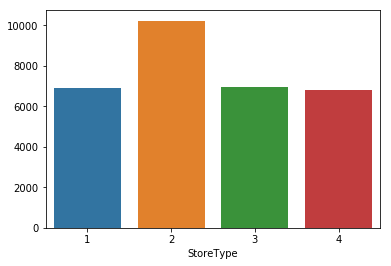

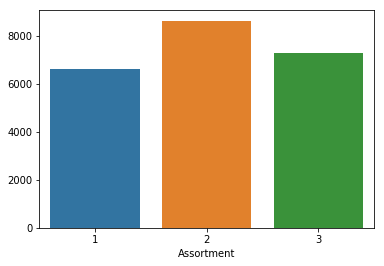

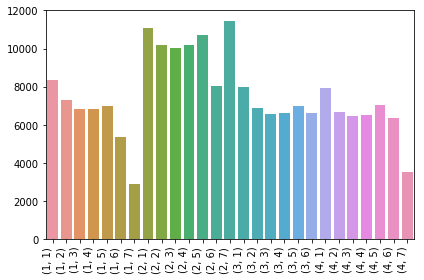

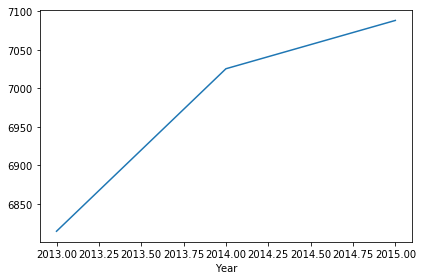

In [12]:
ST_gp = train.groupby('StoreType')['Sales'].agg('mean')
import seaborn as sns
sns.barplot(ST_gp.index,ST_gp.values)
plt.show()

As_gp = train.groupby('Assortment')['Sales'].agg('mean')
sns.barplot(As_gp.index,As_gp.values)
plt.show()
Dayweek_gp = train.groupby(['StoreType','DayOfWeek'])['Sales'].agg('mean')
ax = sns.barplot(Dayweek_gp.index,Dayweek_gp.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

#每年销售额的趋势
YearS_gp = train.groupby(['Year'])['Sales'].agg("mean")
ax2 = sns.lineplot(YearS_gp.index,YearS_gp.values)
plt.tight_layout()
plt.show()

In [13]:
#split train vaild data
from sklearn.model_selection import train_test_split
X_train, X_valid = train_test_split(train, test_size=0.012, random_state=10)
print(X_train.shape)
print(X_valid.shape)
Y_train = X_train["Sales"]
Y_valid = X_valid["Sales"]
X_train.drop("Sales",axis=1,inplace=True)
X_valid.drop("Sales",axis=1,inplace=True)

(834259, 12)
(10133, 12)


/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


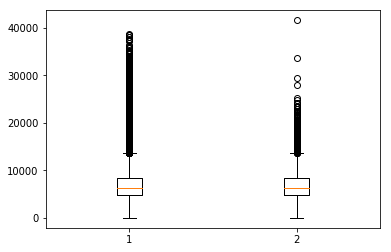

In [14]:
plt.boxplot([Y_train,Y_valid])
plt.show()

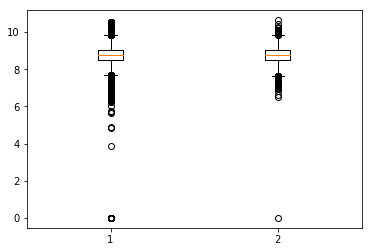

In [15]:
Y_train = np.log1p(Y_train)
Y_valid = np.log1p(Y_valid)
plt.boxplot([Y_train,Y_valid])
plt.show()

In [16]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [17]:
params = {"objective": "reg:linear",
          "eta": 0.1,
          "max_depth": 5,
          "min_child_weight":1,
          "gamma" :0,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1
          }
num_trees = 300

dtrain = xgb.DMatrix(X_train, Y_train)
dvalid = xgb.DMatrix(X_valid, Y_valid)
dtest = xgb.DMatrix(test)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
ret = {}
import time
start = time.time()
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50,evals_result =ret, feval=rmspe_xg, verbose_eval=True)
end = time.time()
print("Train use time:",end-start)

[0]	eval-rmse:7.43891	train-rmse:7.44342	eval-rmspe:0.999474	train-rmspe:0.999494
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 50 rounds.
[1]	eval-rmse:6.69701	train-rmse:6.70128	eval-rmspe:0.998761	train-rmspe:0.998784
[2]	eval-rmse:6.02948	train-rmse:6.0334	eval-rmspe:0.997473	train-rmspe:0.997501
[3]	eval-rmse:5.42889	train-rmse:5.4325	eval-rmspe:0.995302	train-rmspe:0.995337
[4]	eval-rmse:4.88854	train-rmse:4.89185	eval-rmspe:0.991868	train-rmspe:0.991912
[5]	eval-rmse:4.40238	train-rmse:4.40569	eval-rmspe:0.986707	train-rmspe:0.986769
[6]	eval-rmse:3.96534	train-rmse:3.96832	eval-rmspe:0.97938	train-rmspe:0.979458
[7]	eval-rmse:3.57219	train-rmse:3.57497	eval-rmspe:0.969428	train-rmspe:0.969528
[8]	eval-rmse:3.21886	train-rmse:3.22141	eval-rmspe:0.956444	train-rmspe:0.956575
[9]	eval-rmse:2.90111	train-rmse:2.90349	eval-rmspe:0.940169	train-rmspe:0.940338
[10]	eval-rmse:2.61555	train-rmse:2.

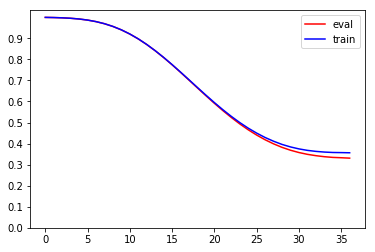

In [18]:
evaldata = ret['eval']['rmspe'][0:37]
traindata = ret['train']['rmspe'][0:37]
plt.plot(range(0,37,1),evaldata,color='red',label="eval")
plt.plot(range(0,37,1),traindata,color='blue',label="train")
plt.legend(loc='best')
y_tick = np.arange(0,1,0.1)
plt.yticks(y_tick)
plt.show()

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(max_depth=5,learning_rate =0.1, n_estimators=36,min_child_weight=1, gamma=0,verbose = 10,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1),
                        param_grid = param_test1,scoring ='neg_mean_squared_error',cv=5)
gsearch1.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=36,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8, verbose=10),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [24]:
print(gsearch1.best_params_)

{'max_depth': 9, 'min_child_weight': 3}


In [26]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBRegressor(max_depth=9,learning_rate =0.1, n_estimators=36,min_child_weight=3, gamma=0,verbose = 10,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1),
                        param_grid = param_test2,scoring ='neg_mean_squared_error',cv=5)

gsearch2.fit(X_train, Y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=3, missing=None, n_estimators=36,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8, verbose=10),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [27]:
print(gsearch2.best_params_)

{'gamma': 0.1}


In [28]:
params2 = {"objective": "reg:linear",
          "eta": 0.1,
          "max_depth": 9,
          "min_child_weight":3,
          "gamma" :0.1,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1
          }

start = time.time()
gbm2 = xgb.train(params2, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50,evals_result =ret, feval=rmspe_xg, verbose_eval=True)
end = time.time()

[0]	eval-rmse:7.43895	train-rmse:7.44331	eval-rmspe:0.999475	train-rmspe:0.999495
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 50 rounds.
[1]	eval-rmse:6.69672	train-rmse:6.70106	eval-rmspe:0.998765	train-rmspe:0.998787
[2]	eval-rmse:6.02929	train-rmse:6.03311	eval-rmspe:0.997482	train-rmspe:0.997509
[3]	eval-rmse:5.42853	train-rmse:5.43198	eval-rmspe:0.995327	train-rmspe:0.99536
[4]	eval-rmse:4.88797	train-rmse:4.89106	eval-rmspe:0.991922	train-rmspe:0.991961
[5]	eval-rmse:4.40157	train-rmse:4.40452	eval-rmspe:0.98682	train-rmspe:0.986867
[6]	eval-rmse:3.96423	train-rmse:3.96687	eval-rmspe:0.979558	train-rmspe:0.979617
[7]	eval-rmse:3.57077	train-rmse:3.57309	eval-rmspe:0.969721	train-rmspe:0.969789
[8]	eval-rmse:3.21687	train-rmse:3.2191	eval-rmspe:0.95687	train-rmspe:0.956965
[9]	eval-rmse:2.8985	train-rmse:2.90043	eval-rmspe:0.940834	train-rmspe:0.94094
[10]	eval-rmse:2.61229	train-rmse:2.614

[96]	eval-rmse:0.200751	train-rmse:0.195021	eval-rmspe:0.194258	train-rmspe:0.248474
[97]	eval-rmse:0.200339	train-rmse:0.19455	eval-rmspe:0.193791	train-rmspe:0.248069
[98]	eval-rmse:0.200083	train-rmse:0.19427	eval-rmspe:0.193456	train-rmspe:0.248013
[99]	eval-rmse:0.19911	train-rmse:0.193303	eval-rmspe:0.192344	train-rmspe:0.247181
[100]	eval-rmse:0.198339	train-rmse:0.19254	eval-rmspe:0.19145	train-rmspe:0.246679
[101]	eval-rmse:0.197282	train-rmse:0.191415	eval-rmspe:0.190145	train-rmspe:0.245514
[102]	eval-rmse:0.195907	train-rmse:0.189929	eval-rmspe:0.188572	train-rmspe:0.244127
[103]	eval-rmse:0.19564	train-rmse:0.18961	eval-rmspe:0.188277	train-rmspe:0.243994
[104]	eval-rmse:0.19416	train-rmse:0.188115	eval-rmspe:0.186453	train-rmspe:0.242549
[105]	eval-rmse:0.193815	train-rmse:0.187635	eval-rmspe:0.185976	train-rmspe:0.242049
[106]	eval-rmse:0.193666	train-rmse:0.187485	eval-rmspe:0.185805	train-rmspe:0.241774
[107]	eval-rmse:0.192994	train-rmse:0.186675	eval-rmspe:0.185061	t

[192]	eval-rmse:0.160748	train-rmse:0.150977	eval-rmspe:0.14658	train-rmspe:0.205666
[193]	eval-rmse:0.160536	train-rmse:0.150734	eval-rmspe:0.146323	train-rmspe:0.204917
[194]	eval-rmse:0.160518	train-rmse:0.150717	eval-rmspe:0.146303	train-rmspe:0.204905
[195]	eval-rmse:0.16037	train-rmse:0.150575	eval-rmspe:0.146128	train-rmspe:0.204693
[196]	eval-rmse:0.160296	train-rmse:0.15044	eval-rmspe:0.146051	train-rmspe:0.204507
[197]	eval-rmse:0.160179	train-rmse:0.150267	eval-rmspe:0.14589	train-rmspe:0.204254
[198]	eval-rmse:0.159876	train-rmse:0.149916	eval-rmspe:0.145588	train-rmspe:0.203988
[199]	eval-rmse:0.159804	train-rmse:0.149811	eval-rmspe:0.145538	train-rmspe:0.203685
[200]	eval-rmse:0.159559	train-rmse:0.149565	eval-rmspe:0.145253	train-rmspe:0.203216
[201]	eval-rmse:0.15945	train-rmse:0.149396	eval-rmspe:0.145123	train-rmspe:0.203105
[202]	eval-rmse:0.158957	train-rmse:0.148908	eval-rmspe:0.144544	train-rmspe:0.202712
[203]	eval-rmse:0.158844	train-rmse:0.148741	eval-rmspe:0.1

[288]	eval-rmse:0.147928	train-rmse:0.135508	eval-rmspe:0.130726	train-rmspe:0.188008
[289]	eval-rmse:0.147904	train-rmse:0.135464	eval-rmspe:0.130675	train-rmspe:0.187962
[290]	eval-rmse:0.147795	train-rmse:0.135359	eval-rmspe:0.130561	train-rmspe:0.18781
[291]	eval-rmse:0.147784	train-rmse:0.135345	eval-rmspe:0.130548	train-rmspe:0.187799
[292]	eval-rmse:0.147772	train-rmse:0.135279	eval-rmspe:0.130519	train-rmspe:0.187754
[293]	eval-rmse:0.147672	train-rmse:0.135136	eval-rmspe:0.130406	train-rmspe:0.187507
[294]	eval-rmse:0.147631	train-rmse:0.135036	eval-rmspe:0.130351	train-rmspe:0.187456
[295]	eval-rmse:0.147561	train-rmse:0.13494	eval-rmspe:0.130262	train-rmspe:0.187384
[296]	eval-rmse:0.147265	train-rmse:0.134669	eval-rmspe:0.129833	train-rmspe:0.187156
[297]	eval-rmse:0.14724	train-rmse:0.134576	eval-rmspe:0.129789	train-rmspe:0.187081
[298]	eval-rmse:0.147194	train-rmse:0.134512	eval-rmspe:0.129769	train-rmspe:0.186986
[299]	eval-rmse:0.147057	train-rmse:0.134328	eval-rmspe:0

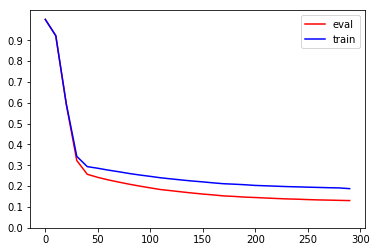

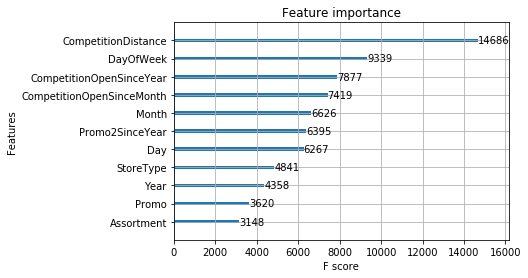

In [33]:
#从最终的训练importnace中看果然是时间序列影响比较大
evaldata = ret['eval']['rmspe'][0:num_trees:10]
traindata = ret['train']['rmspe'][0:num_trees:10]
plt.plot(range(0,num_trees,10),evaldata,color='red',label="eval")
plt.plot(range(0,num_trees,10),traindata,color='blue',label="train")
plt.legend(loc='best')
y_tick = np.arange(0,1,0.1)
plt.yticks(y_tick)
plt.show()
xgb.plot_importance(gbm2)

In [30]:
#预测测试数据
regetTest = pd.read_csv("./test.csv")
replaceID = regetTest[regetTest.Open == 0.0]['Id']
print(replaceID.values)
test_probs = gbm2.predict(dtest)
result = pd.DataFrame({"Id": TESTID , 'Sales': np.exp(test_probs)})
result.loc[result['Id'].isin(replaceID.values),'Sales'] = 0

[  544   677   841 ... 40230 40231 40232]


In [31]:
#预测测试数据输出
result.to_csv("xgboost_submission.csv", index=False)